In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                           roc_auc_score, roc_curve, precision_recall_curve)
from sklearn.feature_selection import SelectKBest, f_classif, RFE
import warnings
warnings.filterwarnings('ignore')

In [54]:
# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# Step 1: Load and Explore the Dataset


In [55]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
df = pd.read_csv('/content/drive/MyDrive/422/data.csv')

In [57]:
print(f"Dataset Shape: {df.shape}")
print(f"Features: {df.columns.tolist()}")

Dataset Shape: (569, 33)
Features: ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32']


In [58]:
print(f"Missing Values: {df.isnull().sum().sum()}")

Missing Values: 569


In [59]:
print("First 5 rows:")
print(df.head())

First 5 rows:
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_wor

In [60]:
print(f"Target Distribution:")
target_counts = df['diagnosis'].value_counts()
print(target_counts)
print(f"Malignant (M): {target_counts.get('M', 0)} ({target_counts.get('M', 0)/len(df)*100:.1f}%)")
print(f"Benign (B): {target_counts.get('B', 0)} ({target_counts.get('B', 0)/len(df)*100:.1f}%)")

Target Distribution:
diagnosis
B    357
M    212
Name: count, dtype: int64
Malignant (M): 212 (37.3%)
Benign (B): 357 (62.7%)


# Step 2: Data Preprocessing and Feature Engineering

In [61]:
# Remove unnecessary columns (if they exist)
columns_to_drop = ['id', 'Unnamed: 32'] if 'Unnamed: 32' in df.columns else ['id'] if 'id' in df.columns else []
if columns_to_drop:
    df = df.drop(columns=columns_to_drop, errors='ignore')

In [62]:
# Encode target variable
le = LabelEncoder()
df['diagnosis_encoded'] = le.fit_transform(df['diagnosis'])
print(f"Target encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Target encoding: {'B': np.int64(0), 'M': np.int64(1)}


In [63]:
# Separate features and target
X = df.drop(['diagnosis', 'diagnosis_encoded'], axis=1)
y = df['diagnosis_encoded']

In [64]:
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (569, 30)
Target shape: (569,)


# Step 3: Feature Analysis and Selection

In [65]:
print("Feature Statistics:")
print(X.describe().round(2))

Feature Statistics:
       radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
count       569.00        569.00          569.00     569.00           569.00   
mean         14.13         19.29           91.97     654.89             0.10   
std           3.52          4.30           24.30     351.91             0.01   
min           6.98          9.71           43.79     143.50             0.05   
25%          11.70         16.17           75.17     420.30             0.09   
50%          13.37         18.84           86.24     551.10             0.10   
75%          15.78         21.80          104.10     782.70             0.11   
max          28.11         39.28          188.50    2501.00             0.16   

       compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
count            569.00          569.00               569.00         569.00   
mean               0.10            0.09                 0.05           0.18   
std                0.0

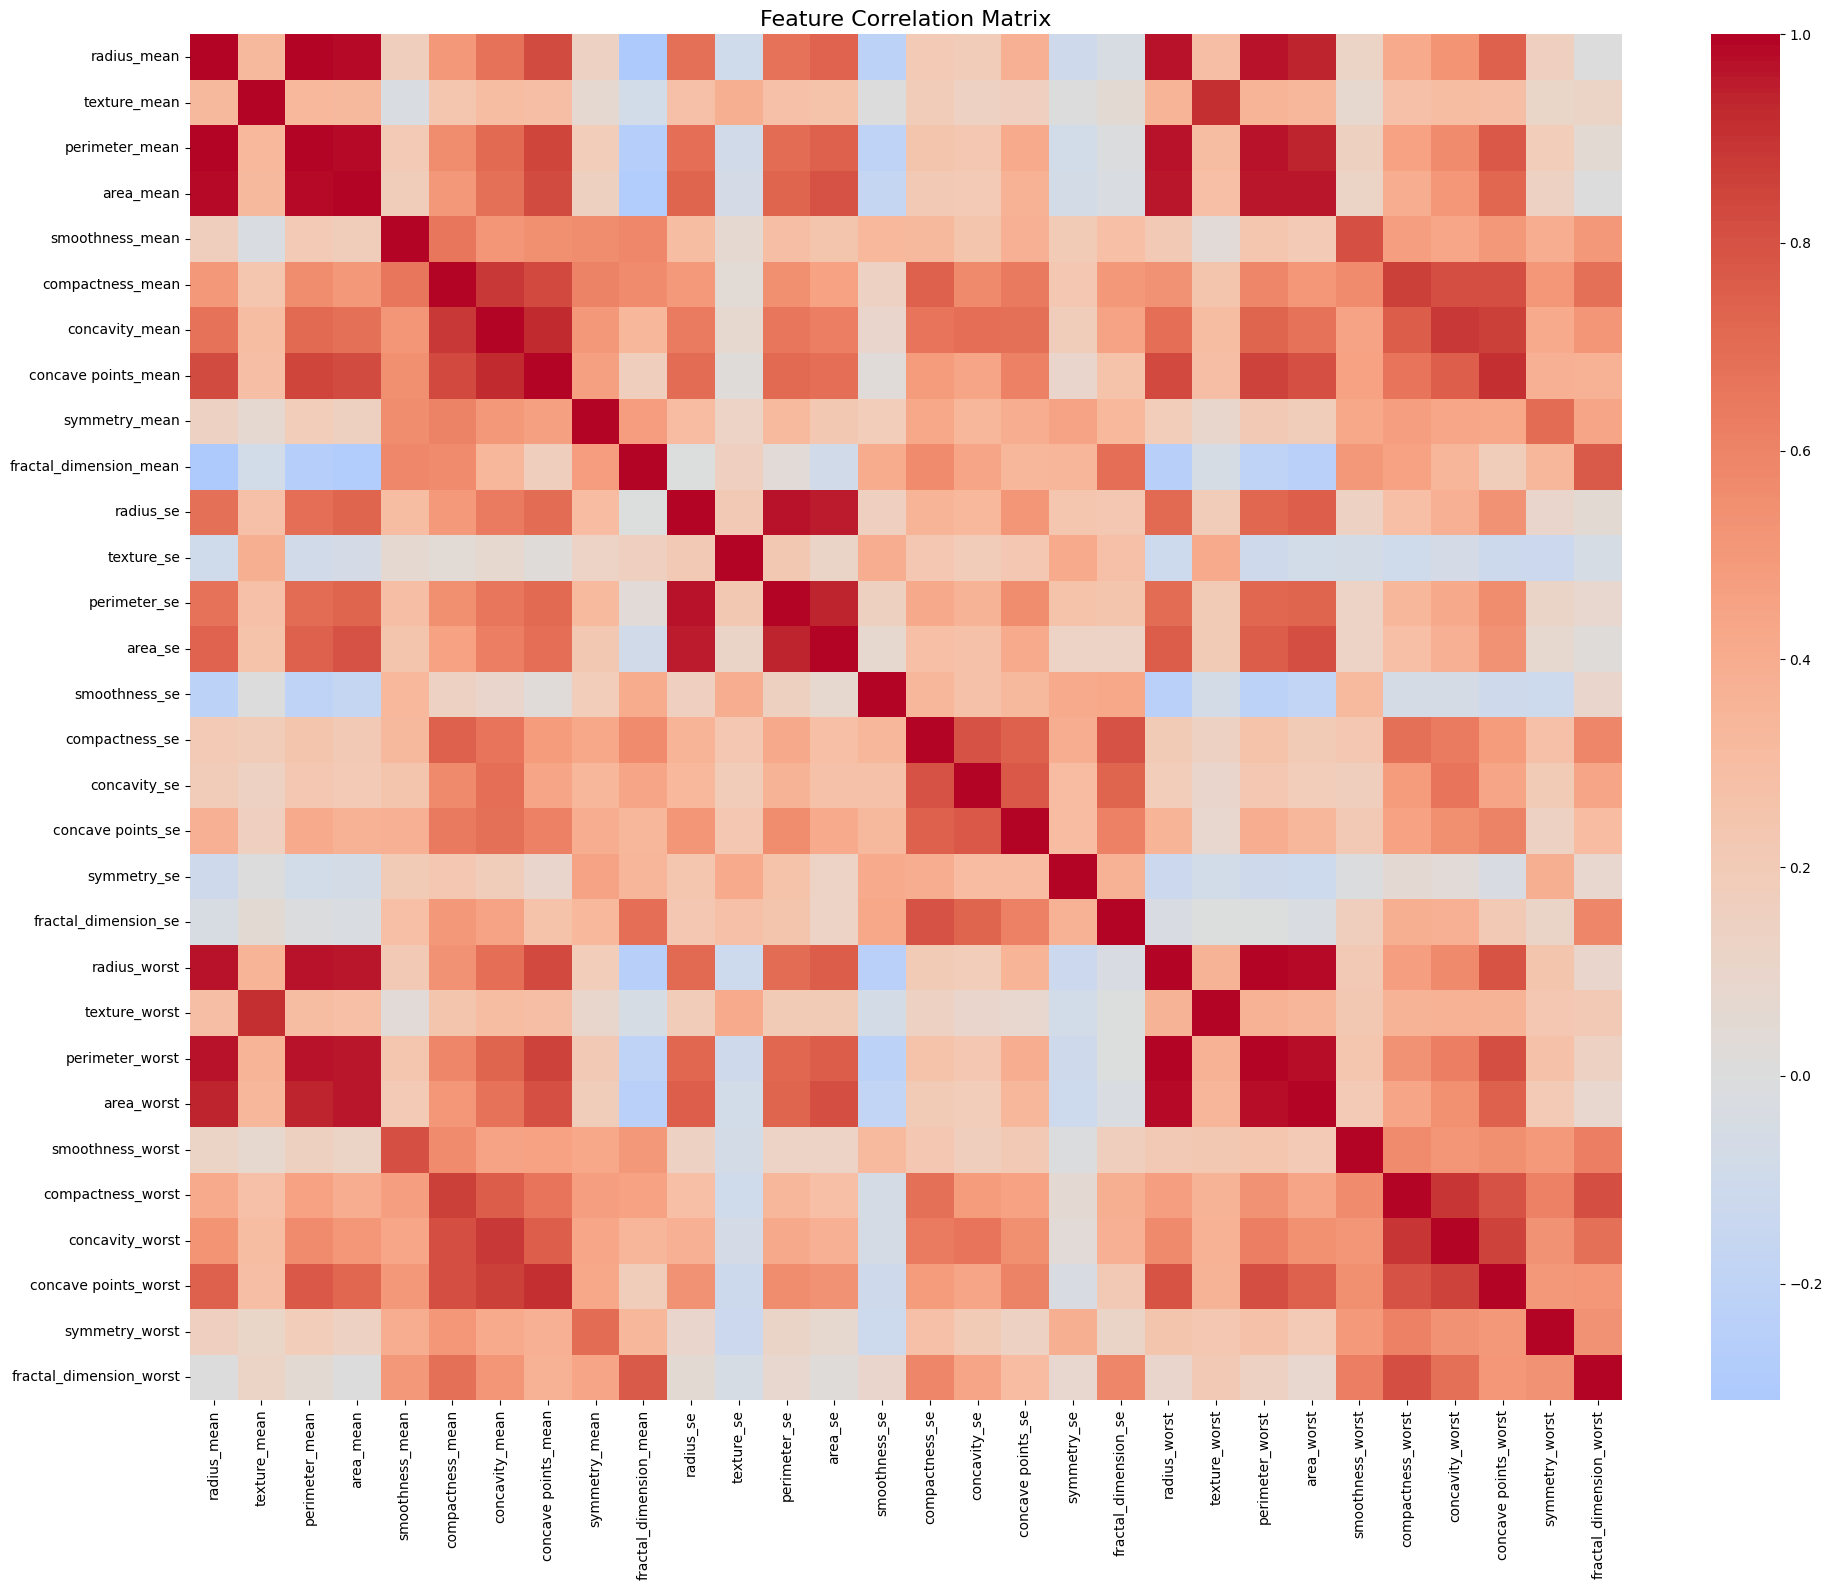

In [66]:
correlation_matrix = X.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

In [67]:
# Method 1: Remove low variance features
from sklearn.feature_selection import VarianceThreshold
variance_selector = VarianceThreshold(threshold=0.1)
X_variance_selected = variance_selector.fit_transform(X)
print(f"1. After variance threshold: {X_variance_selected.shape[1]} features")

1. After variance threshold: 11 features


In [68]:
# Method 2: Univariate feature selection
univariate_selector = SelectKBest(score_func=f_classif, k=20)
X_univariate_selected = univariate_selector.fit_transform(X, y)
selected_features_univariate = X.columns[univariate_selector.get_support()]
print(f"2. After univariate selection: {len(selected_features_univariate)} features")

2. After univariate selection: 20 features


In [69]:
# Method 3: Recursive Feature Elimination
rf_for_rfe = RandomForestClassifier(n_estimators=100, random_state=42)
rfe_selector = RFE(estimator=rf_for_rfe, n_features_to_select=15)
X_rfe_selected = rfe_selector.fit_transform(X, y)
selected_features_rfe = X.columns[rfe_selector.get_support()]
print(f"3. After RFE selection: {len(selected_features_rfe)} features")

3. After RFE selection: 15 features


In [70]:
print(f"RFE Selected Features: {list(selected_features_rfe)}")

RFE Selected Features: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'concavity_mean', 'concave points_mean', 'area_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst']


In [71]:
# Use RFE selected features for modeling
X_selected = X[selected_features_rfe]

# Step 4: Data Splitting and Scaling

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

In [73]:
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (455, 15)
Test set: (114, 15)


In [74]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Model Training and Evaluation

In [75]:
results = {}
model_objects = {}


In [76]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

rf_pred  = rf_clf.predict(X_test)
rf_proba = rf_clf.predict_proba(X_test)[:, 1]

rf_acc = accuracy_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_proba)
rf_cv  = cross_val_score(rf_clf, X_train, y_train, cv=5)

print(f"Random Forest: Accuracy = {rf_acc:.4f}, ROC-AUC = {rf_auc:.4f}")

results['Random Forest']      = {'Accuracy': rf_acc, 'ROC-AUC': rf_auc,
                                 'CV Mean': rf_cv.mean(), 'CV Std': rf_cv.std()}
model_objects['Random Forest'] = rf_clf


Random Forest: Accuracy = 0.9737, ROC-AUC = 0.9952


In [77]:

gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_clf.fit(X_train, y_train)

gb_pred  = gb_clf.predict(X_test)
gb_proba = gb_clf.predict_proba(X_test)[:, 1]

gb_acc = accuracy_score(y_test, gb_pred)
gb_auc = roc_auc_score(y_test, gb_proba)
gb_cv  = cross_val_score(gb_clf, X_train, y_train, cv=5)

print(f"Gradient Boosting: Accuracy = {gb_acc:.4f}, ROC-AUC = {gb_auc:.4f}")

results['Gradient Boosting']      = {'Accuracy': gb_acc, 'ROC-AUC': gb_auc,
                                     'CV Mean': gb_cv.mean(), 'CV Std': gb_cv.std()}
model_objects['Gradient Boosting'] = gb_clf


Gradient Boosting: Accuracy = 0.9649, ROC-AUC = 0.9950


In [78]:


ada_clf = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_clf.fit(X_train, y_train)

ada_pred  = ada_clf.predict(X_test)
ada_proba = ada_clf.predict_proba(X_test)[:, 1]

ada_acc = accuracy_score(y_test, ada_pred)
ada_auc = roc_auc_score(y_test, ada_proba)
ada_cv  = cross_val_score(ada_clf, X_train, y_train, cv=5)

print(f"AdaBoost: Accuracy = {ada_acc:.4f}, ROC-AUC = {ada_auc:.4f}")

results['AdaBoost']      = {'Accuracy': ada_acc, 'ROC-AUC': ada_auc,
                            'CV Mean': ada_cv.mean(), 'CV Std': ada_cv.std()}
model_objects['AdaBoost'] = ada_clf


AdaBoost: Accuracy = 0.9649, ROC-AUC = 0.9914


In [79]:

lr_clf = LogisticRegression(random_state=42, max_iter=1000)
lr_clf.fit(X_train_scaled, y_train)

lr_pred  = lr_clf.predict(X_test_scaled)
lr_proba = lr_clf.predict_proba(X_test_scaled)[:, 1]

lr_acc = accuracy_score(y_test, lr_pred)
lr_auc = roc_auc_score(y_test, lr_proba)
lr_cv  = cross_val_score(lr_clf, X_train_scaled, y_train, cv=5)

print(f"Logistic Regression: Accuracy = {lr_acc:.4f}, ROC-AUC = {lr_auc:.4f}")

results['Logistic Regression']      = {'Accuracy': lr_acc, 'ROC-AUC': lr_auc,
                                       'CV Mean': lr_cv.mean(), 'CV Std': lr_cv.std()}
model_objects['Logistic Regression'] = lr_clf


Logistic Regression: Accuracy = 0.9737, ROC-AUC = 0.9980


In [80]:

svc_clf = SVC(probability=True, random_state=42)
svc_clf.fit(X_train_scaled, y_train)

svc_pred  = svc_clf.predict(X_test_scaled)
svc_proba = svc_clf.predict_proba(X_test_scaled)[:, 1]

svc_acc = accuracy_score(y_test, svc_pred)
svc_auc = roc_auc_score(y_test, svc_proba)
svc_cv  = cross_val_score(svc_clf, X_train_scaled, y_train, cv=5)

print(f"Support Vector Classifier: Accuracy = {svc_acc:.4f}, ROC-AUC = {svc_auc:.4f}")

results['Support Vector Classifier']      = {'Accuracy': svc_acc, 'ROC-AUC': svc_auc,
                                             'CV Mean': svc_cv.mean(), 'CV Std': svc_cv.std()}
model_objects['Support Vector Classifier'] = svc_clf


Support Vector Classifier: Accuracy = 0.9825, ROC-AUC = 0.9970


In [81]:

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_scaled, y_train)

knn_pred  = knn_clf.predict(X_test_scaled)
knn_proba = knn_clf.predict_proba(X_test_scaled)[:, 1]

knn_acc = accuracy_score(y_test, knn_pred)
knn_auc = roc_auc_score(y_test, knn_proba)
knn_cv  = cross_val_score(knn_clf, X_train_scaled, y_train, cv=5)

print(f"K-Nearest Neighbors: Accuracy = {knn_acc:.4f}, ROC-AUC = {knn_auc:.4f}")

results['K-Nearest Neighbors']      = {'Accuracy': knn_acc, 'ROC-AUC': knn_auc,
                                       'CV Mean': knn_cv.mean(), 'CV Std': knn_cv.std()}
model_objects['K-Nearest Neighbors'] = knn_clf


K-Nearest Neighbors: Accuracy = 0.9825, ROC-AUC = 0.9980


In [82]:

dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

dt_pred  = dt_clf.predict(X_test)
dt_proba = dt_clf.predict_proba(X_test)[:, 1]

dt_acc = accuracy_score(y_test, dt_pred)
dt_auc = roc_auc_score(y_test, dt_proba)
dt_cv  = cross_val_score(dt_clf, X_train, y_train, cv=5)

print(f"Decision Tree: Accuracy = {dt_acc:.4f}, ROC-AUC = {dt_auc:.4f}")

results['Decision Tree']      = {'Accuracy': dt_acc, 'ROC-AUC': dt_auc,
                                 'CV Mean': dt_cv.mean(), 'CV Std': dt_cv.std()}
model_objects['Decision Tree'] = dt_clf


Decision Tree: Accuracy = 0.9035, ROC-AUC = 0.8938


In [83]:

mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42, max_iter=1000)
mlp_clf.fit(X_train_scaled, y_train)

mlp_pred  = mlp_clf.predict(X_test_scaled)
mlp_proba = mlp_clf.predict_proba(X_test_scaled)[:, 1]

mlp_acc = accuracy_score(y_test, mlp_pred)
mlp_auc = roc_auc_score(y_test, mlp_proba)
mlp_cv  = cross_val_score(mlp_clf, X_train_scaled, y_train, cv=5)

print(f"Neural Network (MLP): Accuracy = {mlp_acc:.4f}, ROC-AUC = {mlp_auc:.4f}")

results['Neural Network (MLP)']      = {'Accuracy': mlp_acc, 'ROC-AUC': mlp_auc,
                                        'CV Mean': mlp_cv.mean(), 'CV Std': mlp_cv.std()}
model_objects['Neural Network (MLP)'] = mlp_clf


Neural Network (MLP): Accuracy = 0.9912, ROC-AUC = 0.9987


# Step 6: Results Comparison and Visualization

In [84]:
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('Accuracy', ascending=False)

In [85]:
print("Model Performance Ranking:")
print(results_df.round(4))

Model Performance Ranking:
                           Accuracy  ROC-AUC  CV Mean  CV Std
Neural Network (MLP)         0.9912   0.9987   0.9670  0.0197
Support Vector Classifier    0.9825   0.9970   0.9692  0.0128
K-Nearest Neighbors          0.9825   0.9980   0.9560  0.0209
Random Forest                0.9737   0.9952   0.9560  0.0311
Logistic Regression          0.9737   0.9980   0.9736  0.0112
Gradient Boosting            0.9649   0.9950   0.9538  0.0306
AdaBoost                     0.9649   0.9914   0.9670  0.0269
Decision Tree                0.9035   0.8938   0.9297  0.0420


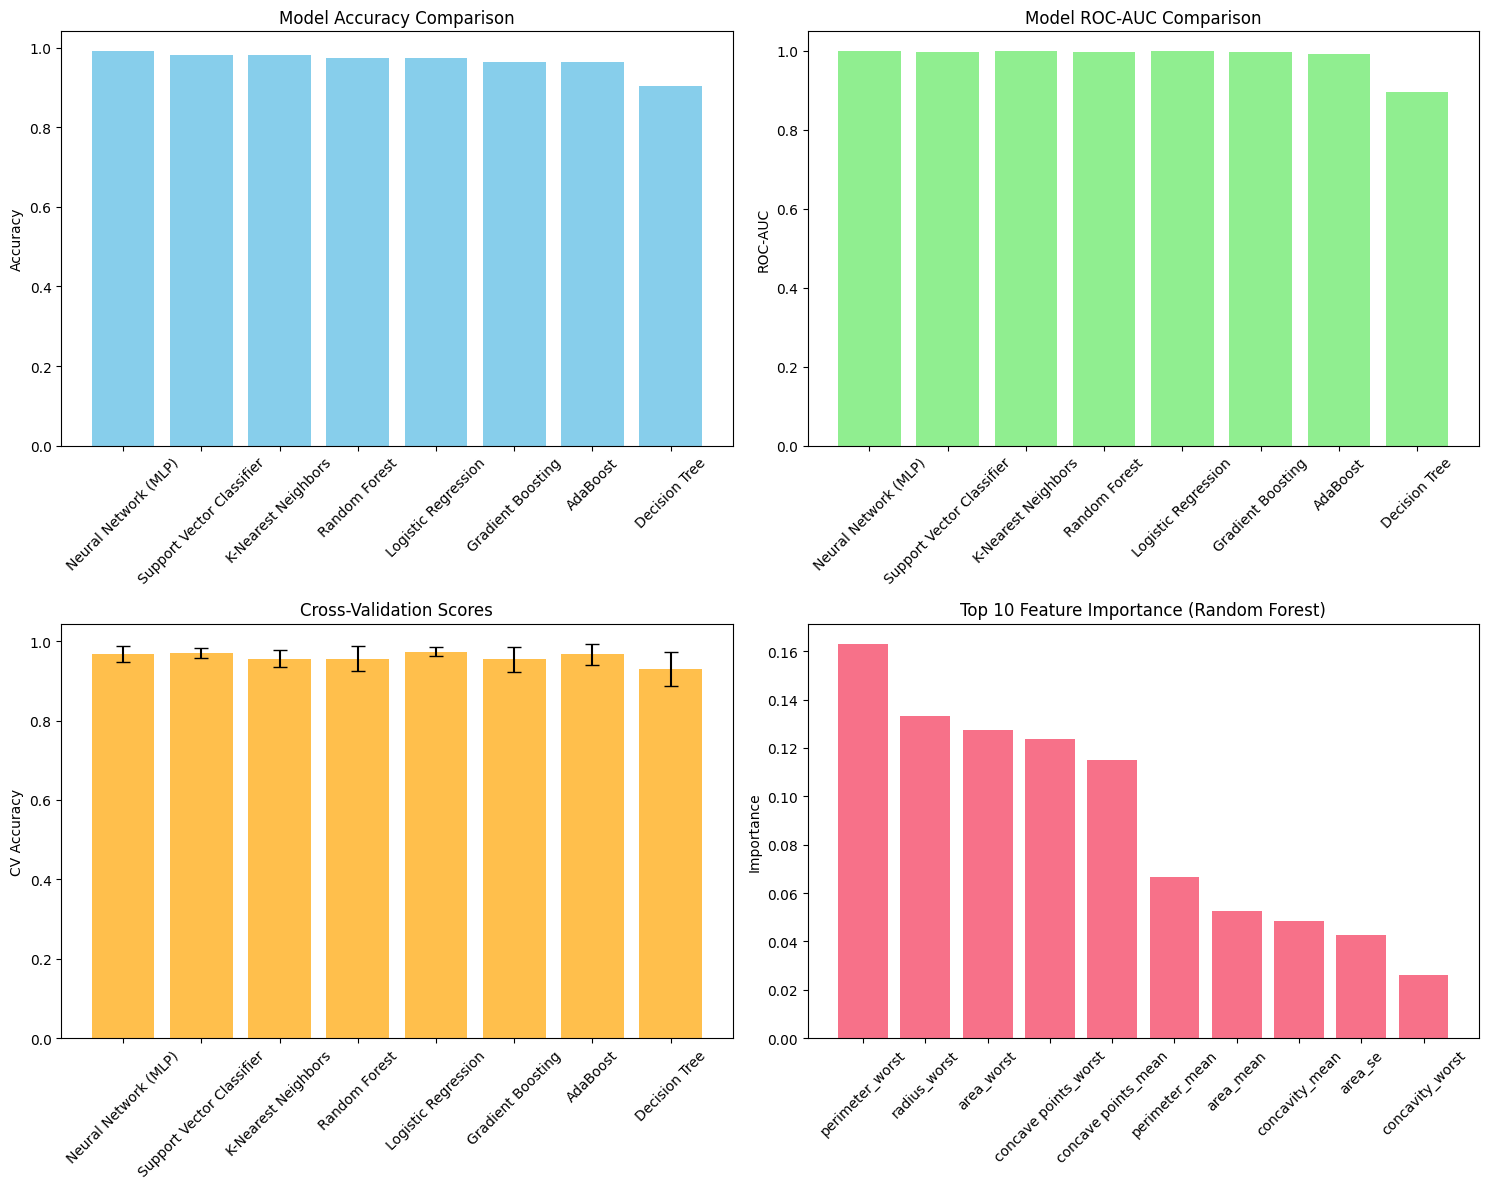

In [86]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy comparison
axes[0, 0].bar(results_df.index, results_df['Accuracy'], color='skyblue')
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)

# ROC-AUC comparison
axes[0, 1].bar(results_df.index, results_df['ROC-AUC'], color='lightgreen')
axes[0, 1].set_title('Model ROC-AUC Comparison')
axes[0, 1].set_ylabel('ROC-AUC')
axes[0, 1].tick_params(axis='x', rotation=45)

# Cross-validation scores
axes[1, 0].bar(results_df.index, results_df['CV Mean'], yerr=results_df['CV Std'],
               color='orange', alpha=0.7, capsize=5)
axes[1, 0].set_title('Cross-Validation Scores')
axes[1, 0].set_ylabel('CV Accuracy')
axes[1, 0].tick_params(axis='x', rotation=45)

# Feature importance (for best tree-based model)
best_tree_model = None
best_tree_score = 0
for name, score in results.items():
    if name in ['Random Forest', 'Gradient Boosting', 'AdaBoost', 'Decision Tree']:
        if score['Accuracy'] > best_tree_score:
            best_tree_score = score['Accuracy']
            best_tree_model = name

if best_tree_model:
    feature_importance = model_objects[best_tree_model].feature_importances_
    sorted_idx = np.argsort(feature_importance)[::-1][:10]

    axes[1, 1].bar(range(len(sorted_idx)), feature_importance[sorted_idx])
    axes[1, 1].set_title(f'Top 10 Feature Importance ({best_tree_model})')
    axes[1, 1].set_ylabel('Importance')
    axes[1, 1].set_xticks(range(len(sorted_idx)))
    axes[1, 1].set_xticklabels([selected_features_rfe[i] for i in sorted_idx], rotation=45)

plt.tight_layout()
plt.show()

# Step 7: Best Model Analysis

In [87]:
best_model_name = results_df.index[0]
best_model = model_objects[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Best Accuracy: {results_df.iloc[0]['Accuracy']:.4f}")

Best Model: Neural Network (MLP)
Best Accuracy: 0.9912


In [88]:
# Detailed evaluation of best model
if best_model_name in ['Logistic Regression', 'Support Vector Classifier', 'K-Nearest Neighbors', 'Neural Network (MLP)']:
    y_pred_best = best_model.predict(X_test_scaled)
    y_pred_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]
else:
    y_pred_best = best_model.predict(X_test)
    y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

In [89]:
print(f"Classification Report for {best_model_name}:")
print(classification_report(y_test, y_pred_best, target_names=['Benign', 'Malignant']))

Classification Report for Neural Network (MLP):
              precision    recall  f1-score   support

      Benign       0.99      1.00      0.99        72
   Malignant       1.00      0.98      0.99        42

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



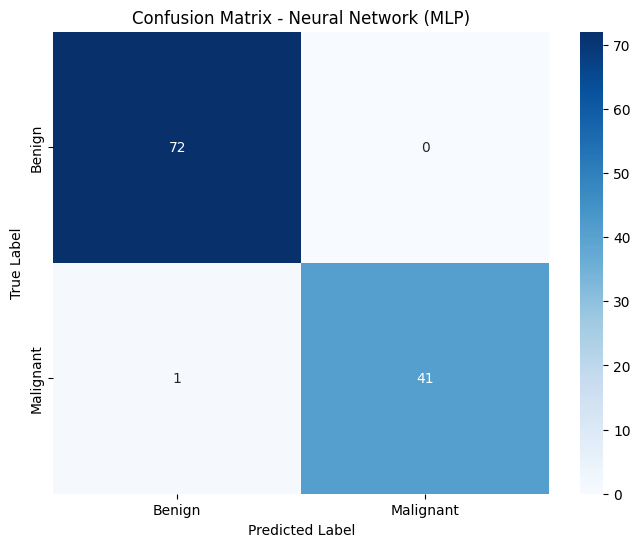

In [90]:
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malignant'],
            yticklabels=['Benign', 'Malignant'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

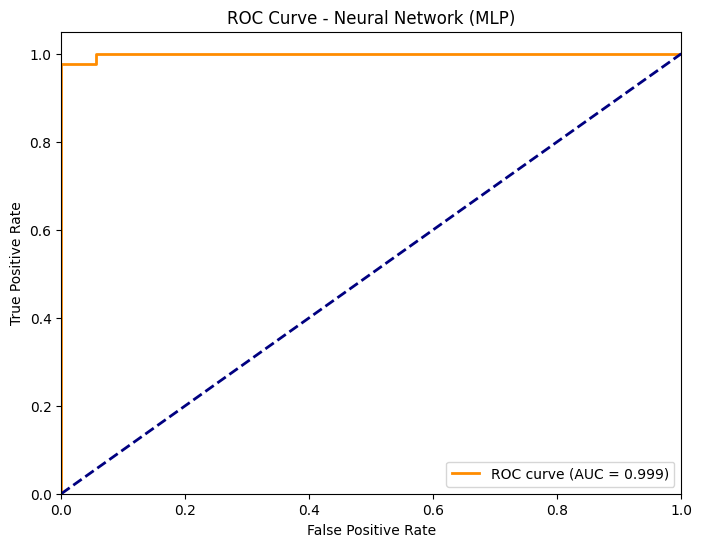

In [91]:
# ROC Curve
fpr, tpr, i = roc_curve(y_test, y_pred_proba_best)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba_best):.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name}')
plt.legend(loc="lower right")
plt.show()

# ***Summary***


Dataset: 569 samples with 30 original features

Target Balance: 357 Benign, 212 Malignant

Selected Features: 15 features after RFE

Best Model: Neural Network (MLP)

Best Accuracy: 0.9912 (99.12%)

ROC-AUC Score: 0.9987